In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed

#our processing code
from ct_tracking_library.ct_motor_functions import *
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *
from ct_tracking_library.ct_object_classes import *
from ct_tracking_library.ct_fk_functions import *

#used for GUI
%matplotlib notebook

#find transform
import datetime
import time
import pickle
from spatialmath import *
from roboticstoolbox import ET as E
import transforms3d as t3d
import itertools

In [2]:
def get_marker(selected_series,time,v = False, debug = False):
    """
    This function finds the marker from the user sleceted dicom file:

    Args:
        selected_series(string): the serial key for the slected DICOM.
        time(Time): time intial when the function is called.
        v(bool): to show visualization for the marker
        debug(bool): wheather or not the user want to see debug info.

    Returns:
        M_list[0](Marker): the moveing marker object finded
        M_list[1](Marker): the fixed marker object finded
        v_mesh(Open3d mesh): the mesh used for finding the marker in form of open3d

    """
    M_list = []
    data_directory = "./test_data/DICOM"
    file_reader = sitk.ImageFileReader()
    series_file_names = {}
    series_IDs = list(sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory))
    if series_IDs:
        for series in series_IDs:
            series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    for S in range(2):
        # pick marker
        if S == 0:
            target_marker_name = 'moving_marker_1_DoF'
            marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
            R = np.eye(3)
            crop_z = None
        else:
            target_marker_name = 'fixed_marker_1_DoF'
            marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
            R = np.eye(3)
            crop_z = None

        #convert scan to mesh for finding markers via thresholding
        scan_file = series_file_names[selected_series]
        convert_scan_to_mha(scan_file, crop_z = crop_z)
        convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj')

        #find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
        _, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=debug)
        if debug:
            print('marker centroid coordinates from design: {}'.format(marker))
            print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

        #display candidate fiducials
        if v:
            o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

        #find best transform and marker from candidate fiducials
        tracked_R, tracked_t, permuted_centroids, min_error = find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters)

        #get rid of column of ones to make 3xN
        permuted_centroids = permuted_centroids[:3,:].T

        #transform marker geometry coordinates using found transform to tracked image coordinates
        transformed_marker = (tracked_R @ marker.T + tracked_t).T
        error = permuted_centroids-transformed_marker
        
        #tracking error from final transform
        np.set_printoptions(2)
        print("Error (mm): {}".format(error))
        print("Error norm (mm): {}".format(np.linalg.norm(error)))
        if v:
            #create o3d visualizations
            marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
            marker_3d_base = create_marker_visualization(marker, [0.2, 0.8, 0.2])
            marker_3d_base.append(create_coordinate_frame_visualization())
            marker_3d_transformed = create_marker_visualization(marker, [0.2, 0.2, 0.8], tracked_R, tracked_t)
            marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))
            #visualize tracked markers on top of mesh used for tracking
            visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
            visualization_list1 = copy.deepcopy(visualization_list2)
            o3d.visualization.draw_geometries(visualization_list2)
        if S == 0:
            v_mesh= marker_mesh
        #append marker
        print("T find: ",tracked_t)
        M_list.append(Marker(name=target_marker_name,d_key=selected_series,time =time,geometry=marker,T=t2T(tracked_R, tracked_t),error=np.linalg.norm(error, axis=1)))
        
    return M_list[0],M_list[1],v_mesh

In [3]:
def plot3l(x_l,y_l,z_l,R):
    plt.figure()
    plt.plot(range(len(x_l)),x_l,linestyle='--', marker='o')
    plt.plot(range(len(y_l)),y_l,linestyle='--', marker='o')
    plt.plot(range(len(z_l)),z_l,linestyle='--', marker='o')
    plt.xlabel("Scan #")
    if R == True:
        plt.ylabel("Euler Angle Degree")
        plt.title("Scan # Vs. Degree")
        plt.legend(['r', 'θ','Φ'])
    else:
        plt.ylabel("Distance(mm)")
        plt.title("Scan # Vs. Distance")
        plt.legend(['X', 'Y','Z'])
    plt.show()

In [4]:
with open('data.pkl', 'rb') as f:
    data_load = pickle.load(f)

In [5]:
u_list = [0,25,50,75]
key_list = ['1.2.840.113619.2.416.6795503943617817801219389912763296544',
           '1.2.840.113619.2.416.6091776499222851246423953174468199664',
           '1.2.840.113619.2.416.100083941475652116358255918161510130375',
           '1.2.840.113619.2.416.61935088023485344866325542289366845877']
ratio = 0.5040628051757813 #converting mm to rev

In [6]:
new_data = {}
mesh_l=[]
for x in range(len(u_list)):
    selected_keys = key_list[x]
    name = 'scan'+str(x)
    marker1,marker2,mesh = get_marker(selected_keys,data_load[name][0].time)
    mesh_l.append(mesh)
    robot = data_load[name][2]
    append_value(new_data, "scan"+str(x), marker1)
    append_value(new_data, "scan"+str(x), marker2)
    append_value(new_data, "scan"+str(x), robot)

spacing:  [0.62500392 0.703125   0.703125  ]
 origin:  [-149.688 -180.    -180.   ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=27
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 9


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\derek\Documents\GitHub\ct-fiducial-tracking\ct_tracking_library\ct_tracking_functions.py:420: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residules, rank, singval = np.linalg.lstsq(A,f)
100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.01it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.0461754  5.95996908]
Everything looks good!
the final error is:  0.04617540065124018
Error (mm): [[ 0.04  0.    0.01]
 [-0.06 -0.01 -0.  ]
 [ 0.04 -0.02 -0.01]
 [-0.02  0.02  0.01]]
Error norm (mm): 0.09235080130248036
T find:  [[-20.19]
 [  3.24]
 [-45.75]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=27
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 192.01it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.8 0.2]
Everything looks good!
the final error is:  0.20084170871052281
Error (mm): [[-0.09 -0.21 -0.01]
 [ 0.14 -0.08 -0.03]
 [-0.05  0.28 -0.  ]
 [-0.    0.01  0.05]]
Error norm (mm): 0.40168341742104563
T find:  [[-13.35]
 [-18.92]
 [ -6.18]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=25
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 144.00it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.05 5.95]
Everything looks good!
the final error is:  0.04823632017360263
Error (mm): [[ 0.03 -0.01  0.01]
 [-0.06 -0.01 -0.01]
 [ 0.06  0.01 -0.02]
 [-0.03  0.02  0.01]]
Error norm (mm): 0.09647264034720525
T find:  [[-45.01]
 [  2.47]
 [-46.26]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=25
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 213.50it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.79 0.19]
Everything looks good!
the final error is:  0.191984967105859
Error (mm): [[-0.08 -0.2  -0.01]
 [ 0.12 -0.07 -0.03]
 [-0.04  0.27 -0.01]
 [-0.   -0.    0.04]]
Error norm (mm): 0.38396993421171804
T find:  [[-13.41]
 [-18.75]
 [ -6.13]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=20
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 187.88it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.05 5.95]
Everything looks good!
the final error is:  0.04992560455091903
Error (mm): [[ 0.04 -0.    0.01]
 [-0.07  0.   -0.  ]
 [ 0.05 -0.01 -0.02]
 [-0.02  0.02  0.01]]
Error norm (mm): 0.09985120910183806
T find:  [[-70.25]
 [  1.67]
 [-46.84]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=20
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 170.68it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.8  0.19]
Everything looks good!
the final error is:  0.19103155522179766
Error (mm): [[-7.93e-02 -2.05e-01 -4.02e-03]
 [ 1.22e-01 -6.07e-02 -3.06e-02]
 [-4.28e-02  2.72e-01 -1.01e-02]
 [-1.39e-04 -6.45e-03  4.47e-02]]
Error norm (mm): 0.3820631104435953
T find:  [[-13.45]
 [-18.66]
 [ -6.13]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=20
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 223.30it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[0.05 5.95]
Everything looks good!
the final error is:  0.05092152397382611
Error (mm): [[ 0.04  0.    0.01]
 [-0.07 -0.01 -0.  ]
 [ 0.05 -0.01 -0.01]
 [-0.03  0.02  0.  ]]
Error norm (mm): 0.10184304794765224
T find:  [[-95.5 ]
 [  0.88]
 [-47.4 ]]


spacing:  [0.63 0.7  0.7 ]
 origin:  [-149.69 -180.   -180.  ]
[Open3D INFO] Skipping non-triangle primitive geometry of type: 1
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=20
[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 170.68it/s]

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2
point cloud has 2 clusters
[0 1 2 3]
[4 5 6 7]
[5.79 0.19]
Everything looks good!
the final error is:  0.19339216458870925
Error (mm): [[-8.24e-02 -2.04e-01 -2.94e-03]
 [ 1.26e-01 -6.29e-02 -3.11e-02]
 [-4.38e-02  2.76e-01 -1.17e-02]
 [-4.53e-05 -8.73e-03  4.57e-02]]
Error norm (mm): 0.3867843291774185
T find:  [[-13.49]
 [-18.6 ]
 [ -6.11]]


<IPython.core.display.Javascript object>


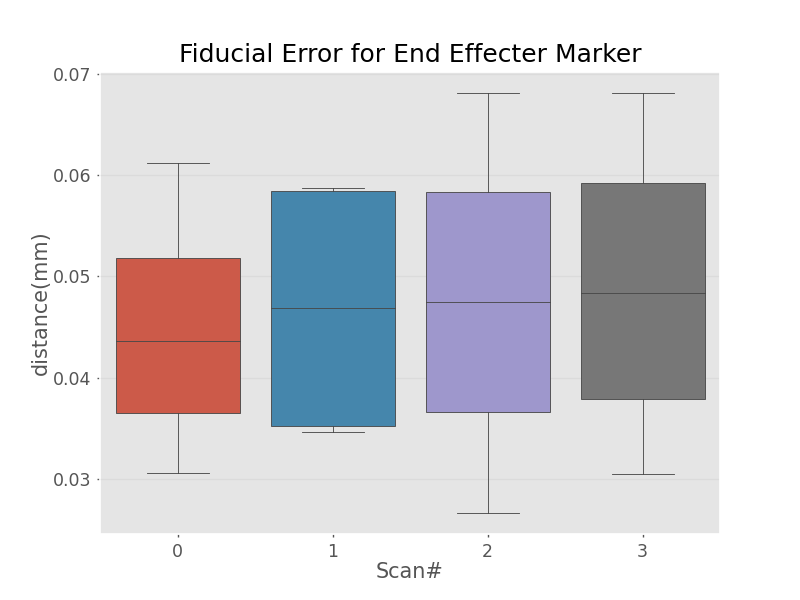

<IPython.core.display.Javascript object>


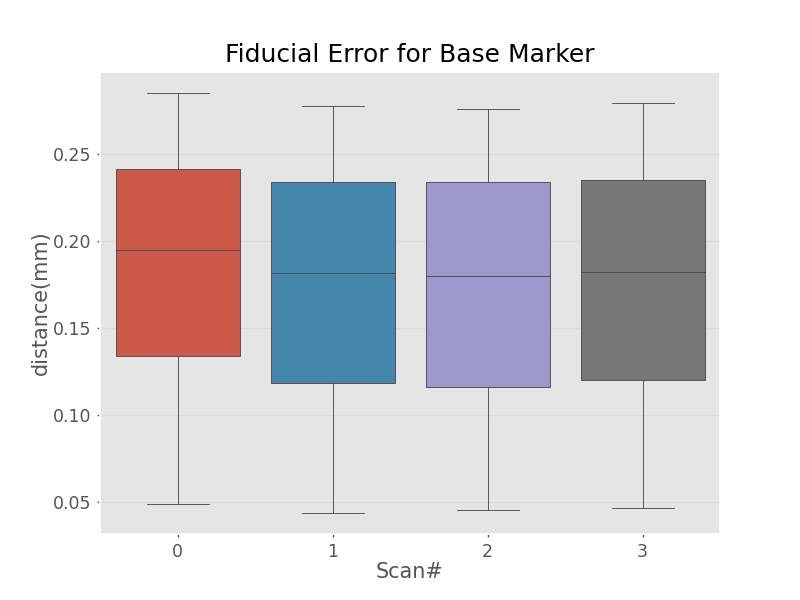

[Text(0.5, 1.0, 'Fiducial Error for Base Marker'),
 Text(0, 0.5, 'distance(mm)'),
 Text(0.5, 0, 'Scan#')]

In [7]:
ee_list = []
b_list = []
for y in new_data:
    ee_list.append(new_data[y][0].error)
    b_list.append(new_data[y][1].error)
sns.boxplot(data=ee_list,  orient='v').set(title='Fiducial Error for End Effecter Marker',ylabel="distance(mm)",xlabel="Scan#")
plt.figure()
sns.boxplot(data=b_list,  orient='v').set(title='Fiducial Error for Base Marker',ylabel="distance(mm)",xlabel="Scan#")

In [8]:
marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
R = np.eye(3)
visualization_list = [mesh]
color = [.8, .6, .8]
for x in new_data:
    print(x)
    marker_3d_tracked = create_marker_visualization(marker, color, SE3(new_data[x][1].T).R, SE3(new_data[x][1].T).t.reshape((3,1))) #blue color
    visualization_list += marker_3d_tracked
    color = [y-.2 for y in color]
o3d.visualization.draw_geometries(visualization_list)

scan0
scan1
scan2
scan3
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]
[Open3D WARNING] invalid color in PaintUniformColor, clipping to [0, 1]


<IPython.core.display.Javascript object>


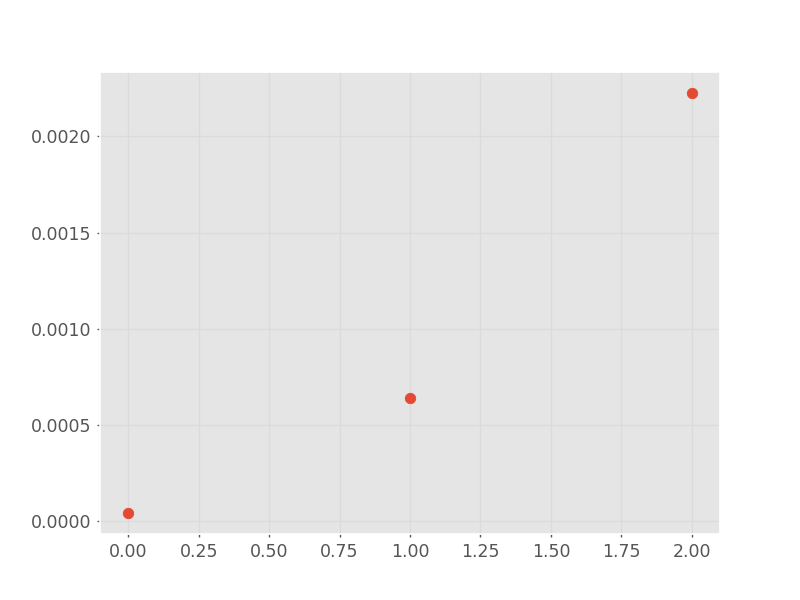

<IPython.core.display.Javascript object>


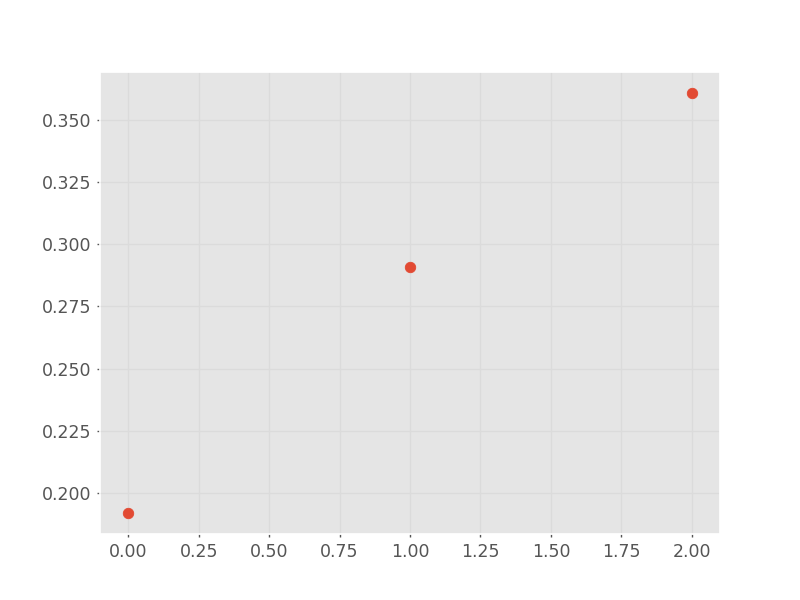

In [9]:
pn = calc_p_error(SE3(new_data['scan1'][1].T).t,SE3(new_data['scan0'][1].T).t)
rn = calc_needle_ori_error(SE3(new_data['scan1'][1].T).R,SE3(new_data['scan0'][1].T).R)
for x in dict(itertools.islice(new_data.items(), 2,4)):
    pn = np.hstack((pn,calc_p_error(SE3(new_data[x][1].T).t,SE3(new_data['scan0'][1].T).t)))
    rn = np.vstack((rn,calc_needle_ori_error(SE3(new_data[x][1].T).R,SE3(new_data['scan0'][1].T).R)))
pnn = np.linalg.norm(pn, axis=0)
rnn = np.linalg.norm(rn, axis=0)
plt.figure()
plt.scatter(range(len(rnn)),rnn)
plt.figure()
plt.scatter(range(len(pnn)),pnn)

### Tsb Base Verfied Plot

<IPython.core.display.Javascript object>


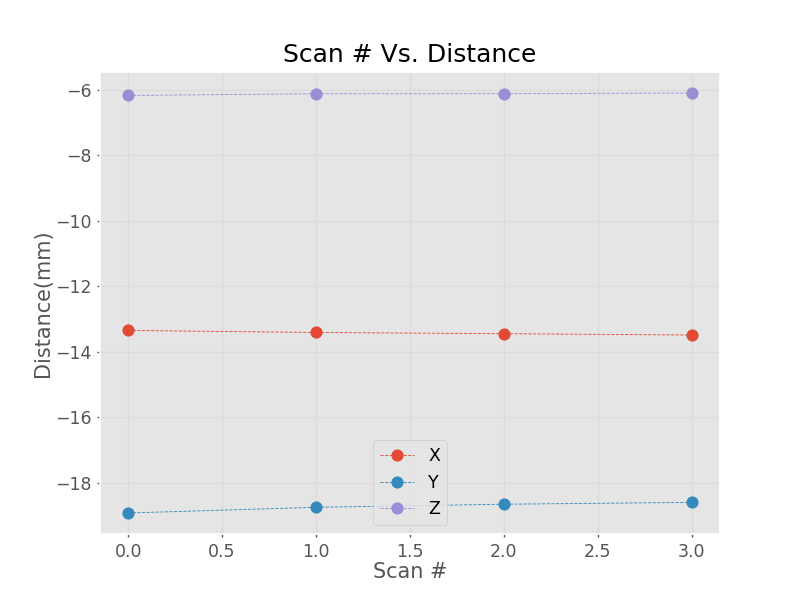

<IPython.core.display.Javascript object>


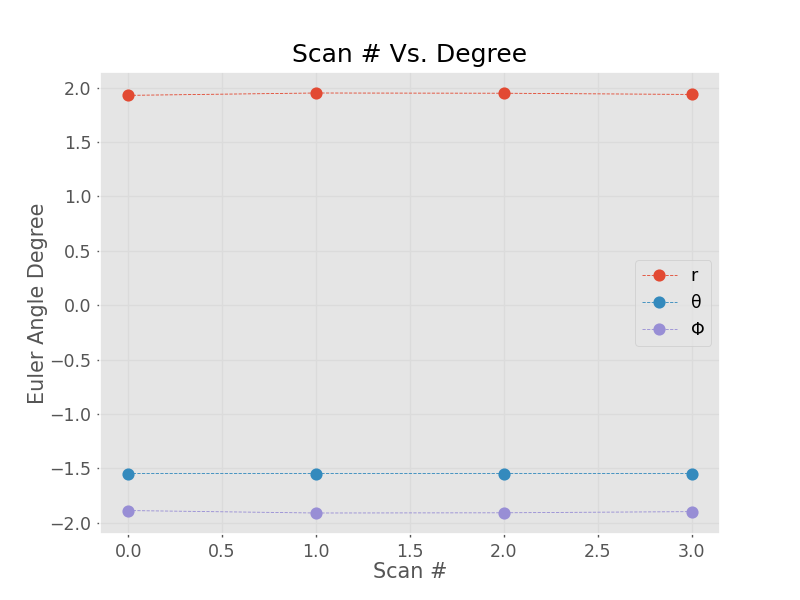

In [10]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    pos = SE3(new_data[x][1].T).t
    ros = R2E(SE3(new_data[x][1].T).R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### Tb EE Verfied Plot

<IPython.core.display.Javascript object>


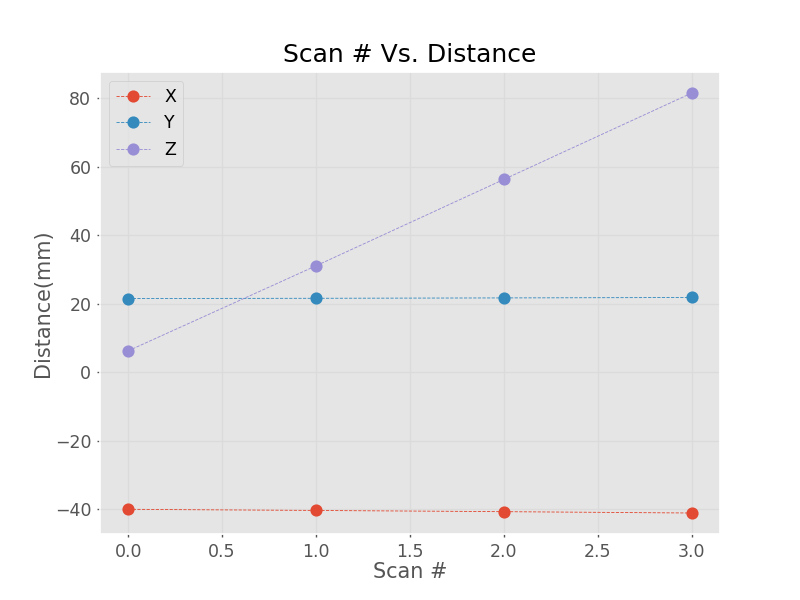

<IPython.core.display.Javascript object>


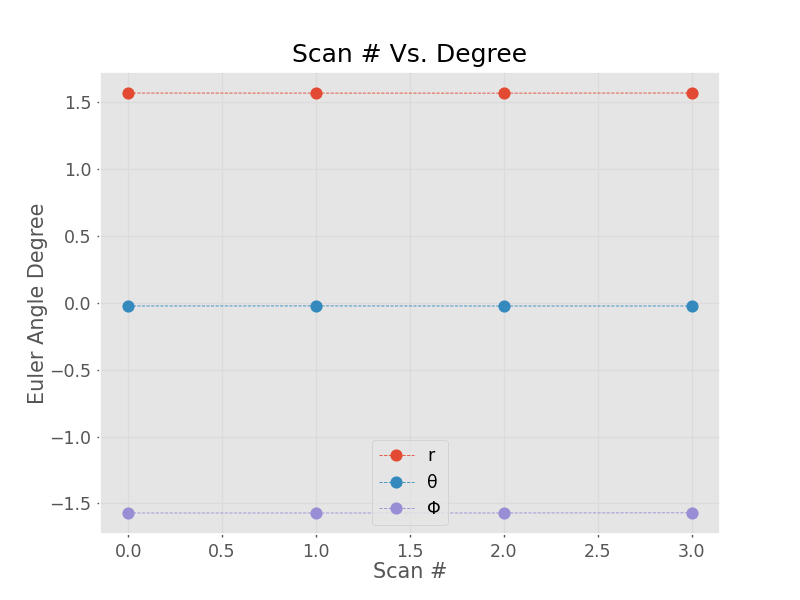

In [11]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
for x in new_data:
    Tbase = SE3(new_data[x][1].T)
    Tee = SE3(new_data[x][0].T)
    Tfinal = Tbase.inv()*Tee
    pos = Tfinal.t
    ros = R2E(Tfinal.R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### TFK Verfied Plot

Postion Error norm(mm):  0.6027676394550517
Rotional Error norm(Euler Angle):  [ 8.31e-20 -1.36e-03  2.61e-04]
Postion Error norm(mm):  0.24948010723577102
Rotional Error norm(Euler Angle):  [ 9.50e-20 -1.55e-03  4.40e-04]
Postion Error norm(mm):  0.21668581681124524
Rotional Error norm(Euler Angle):  [ 1.17e-19 -1.91e-03  2.01e-04]
Postion Error norm(mm):  0.6660464571831188
Rotional Error norm(Euler Angle):  [ 5.19e-20 -8.47e-04 -1.11e-03]


<IPython.core.display.Javascript object>


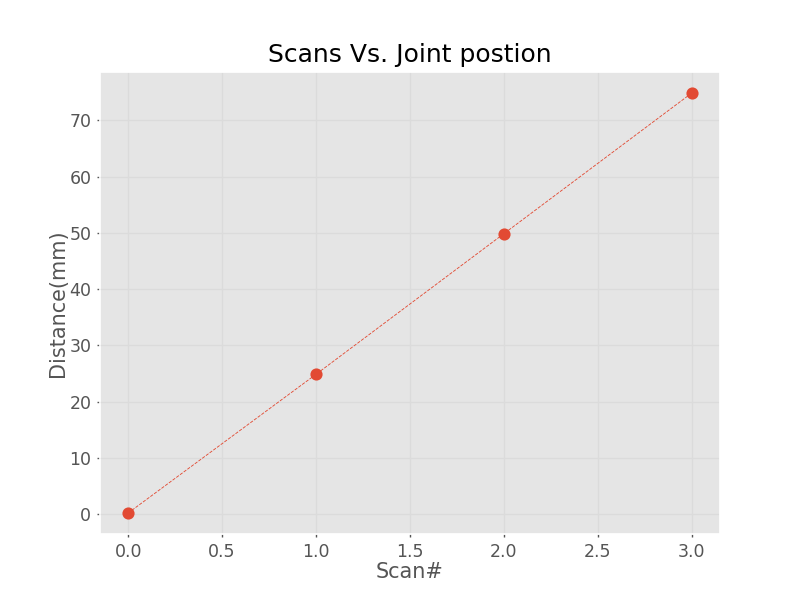

<IPython.core.display.Javascript object>


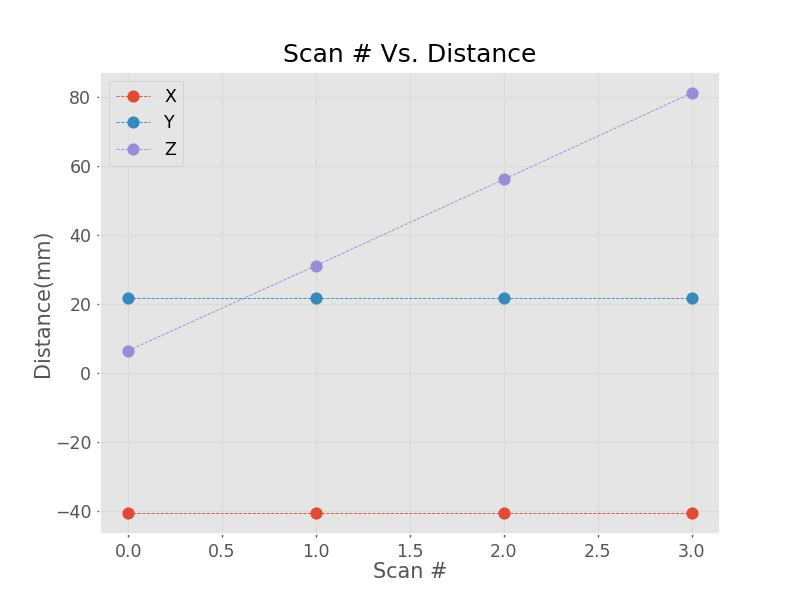

<IPython.core.display.Javascript object>


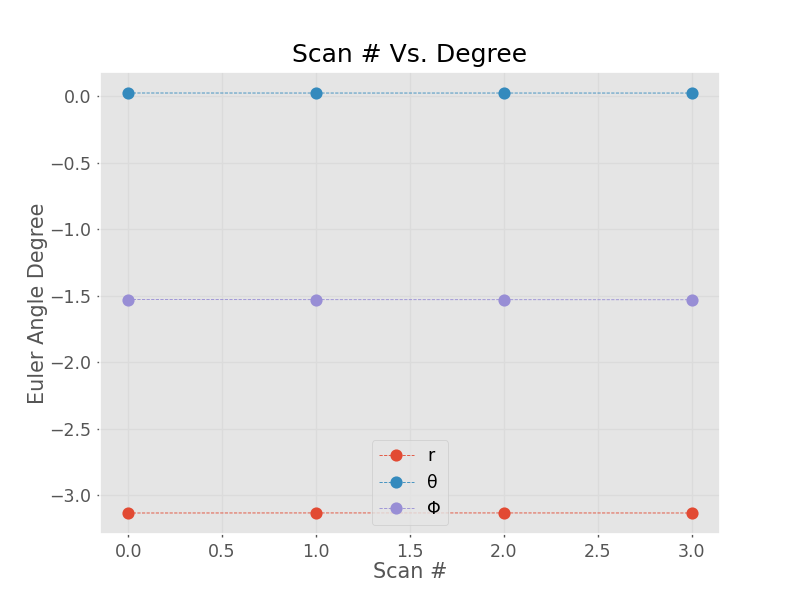

In [16]:
x_l = []
y_l = []
z_l = []
x_r = []
y_r = []
z_r = []
j_l = []
P_norm_list = []
P_list = []
P_std = []
for x in new_data:
    j_l.append(new_data[x][2].joint_postion)
    fk,r_error,p_error = find_fk(new_data[x][0],new_data[x][1],new_data[x][2])
    P_std.append(np.std(p_error))
    P_norm_list.append(np.linalg.norm(p_error))
    P_list.append(p_error)
    pos = (SE3(new_data[x][1].T).inv()*fk).t
    ros = R2E(fk.R)
    x_l.append(pos[0])
    y_l.append(pos[1])
    z_l.append(pos[2])
    x_r.append(ros[0])
    y_r.append(ros[1])
    z_r.append(ros[2])
plt.figure()
plt.plot(j_l,linestyle='--', marker='o')
plt.xlabel("Scan#")
plt.ylabel("Distance(mm)")
plt.title("Scans Vs. Joint postion")
plt.show()
plot3l(x_l,y_l,z_l,False)
plot3l(x_r,y_r,z_r,True)

### Tfk in 3D

In [14]:
for x in range(len(new_data)):
    n = 'scan'+str(x)
    fk,_,_ = find_fk(new_data[n][0],new_data[n][1],new_data[n][2])
    display_fk(fk,new_data[n][0],mesh_l[x])

Postion Error norm(mm):  0.6027676394550517
Rotional Error norm(Euler Angle):  [ 8.31e-20 -1.36e-03  2.61e-04]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
Postion Error norm(mm):  0.24948010723577102
Rotional Error norm(Euler Angle):  [ 9.50e-20 -1.55e-03  4.40e-04]
Postion Error norm(mm):  0.21668581681124524
Rotional Error norm(Euler Angle):  [ 1.17e-19 -1.91e-03  2.01e-04]
Postion Error norm(mm):  0.6660464571831188
Rotional Error norm(Euler Angle):  [ 5.19e-20 -8.47e-04 -1.11e-03]


### Tfk plots

<IPython.core.display.Javascript object>


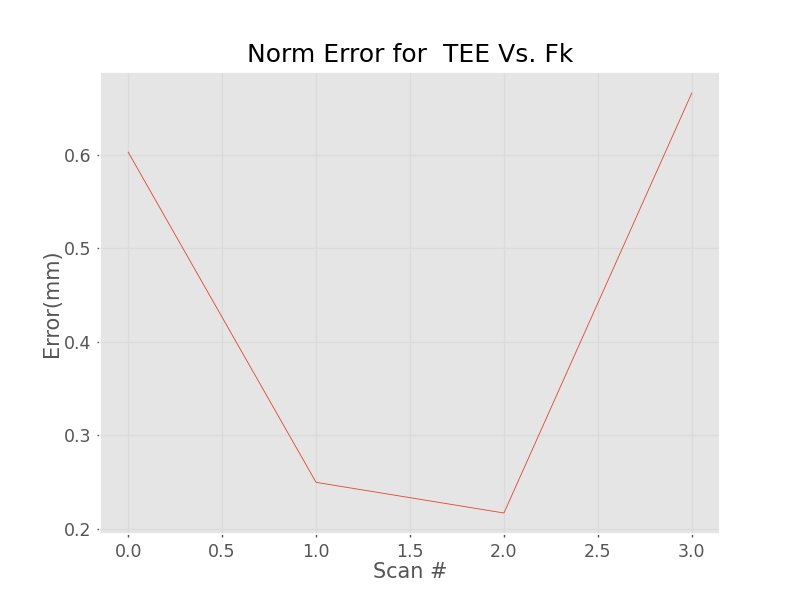

<IPython.core.display.Javascript object>


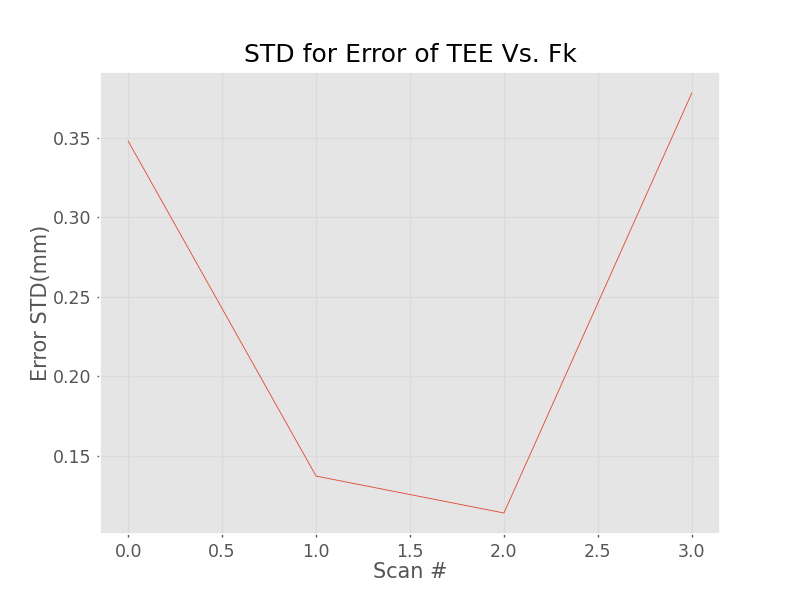

<IPython.core.display.Javascript object>


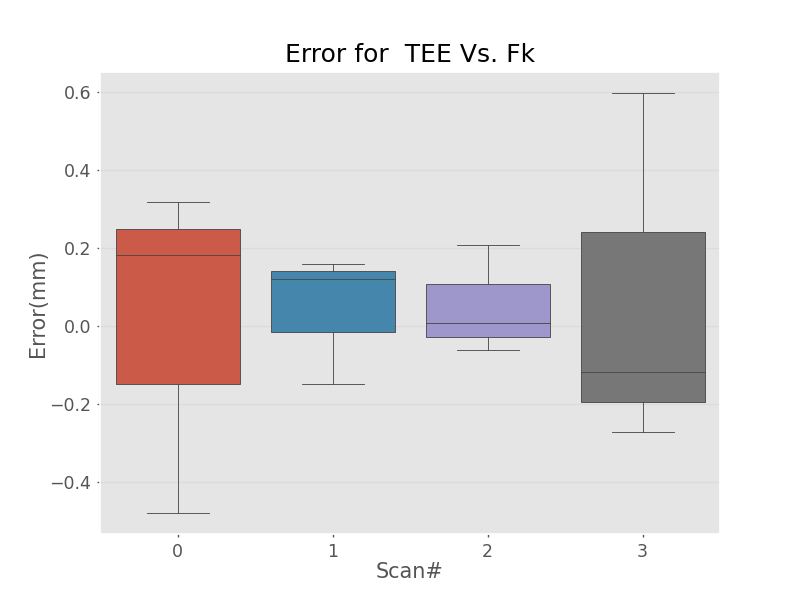

[Text(0.5, 1.0, 'Error for  TEE Vs. Fk'),
 Text(0, 0.5, 'Error(mm)'),
 Text(0.5, 0, 'Scan#')]

In [13]:
plt.plot(P_norm_list)
plt.title("Norm Error for  TEE Vs. Fk")
plt.ylabel("Error(mm)")
plt.xlabel("Scan #")
plt.figure()
plt.plot(P_std)
plt.title("STD for Error of TEE Vs. Fk")
plt.ylabel("Error STD(mm)")
plt.xlabel("Scan #")
plt.figure()
sns.boxplot(data=P_list,  orient='v').set(title='Error for  TEE Vs. Fk',ylabel="Error(mm)",xlabel="Scan#")